In [12]:
import torch
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
import torch.nn as nn
from tqdm import tqdm
from sklearn.cluster import KMeans
from torch.utils.data import DataLoader, TensorDataset
from scipy.stats import pearsonr
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd

In [2]:
# Load data
train_data = torch.load('train.pt')
val_data = torch.load('val.pt')
test_data = torch.load('test.pt')

In [3]:
# Prepare dataset
def prepare_dataset(data):
    eeg_list = []
    stim_list = []
    for eeg, stim in data:
        eeg_list.append(eeg.float())           # (320, 64)
        stim_list.append(stim.float())         # (320,)
    eeg_tensor = torch.stack(eeg_list)         # (N, 320, 64)
    stim_tensor = torch.stack(stim_list)       # (N, 320)
    return eeg_tensor, stim_tensor

X_train, y_train = prepare_dataset(train_data)
X_val, y_val = prepare_dataset(val_data)
X_test, y_test = prepare_dataset(test_data)

In [38]:
config = {
    # Model Architecture
    "input_channels": 64,
    "hidden_channels": 64,
    "gcn_out_channels": 32,
    "fc_out_channels": 1,
    "kernel_size": 5,

    # Loss Weights
    "alpha": 0.6,  # Pearson correlation weight
    "beta": 0.2,   # Cosine similarity weight
    "gamma": 0.1,
    "delta":0.1,

    # Training Parameters
    "learning_rate": 1e-3,
    "batch_size": 16,
    "epochs": 100,
    "use_subset_percentage": 1,

    # Logging
    "log_path": "tgn_eeg_log.csv",

    # Visualization
    "num_test_samples_plot": 5
}

In [39]:
class TGCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, gcn_out_channels, fc_out_channels, kernel_size, adjacency):
        super(TGCN, self).__init__()
        self.adj = self.normalize_adjacency(adjacency)
        self.temporal_conv = nn.Conv1d(in_channels, hidden_channels, kernel_size=kernel_size, padding=kernel_size // 2)
        self.graph_weight = nn.Parameter(torch.Tensor(hidden_channels, gcn_out_channels))
        nn.init.xavier_uniform_(self.graph_weight)
        self.fc = nn.Linear(gcn_out_channels, fc_out_channels)

    def normalize_adjacency(self, A):
        A = A + torch.eye(A.size(0)).to(A.device)
        D_inv_sqrt = torch.diag(torch.pow(A.sum(1), -0.5))
        return D_inv_sqrt @ A @ D_inv_sqrt

    def forward(self, x):
        # x: (batch, time, channels)
        x = x.permute(0, 2, 1)  # → (batch, channels, time)
        x = self.temporal_conv(x)  # → (batch, hidden, time)

        x = x.permute(0, 2, 1)  # → (batch, time, hidden)
        A_hat = self.adj.to(x.device)  # shape: (channels, channels)

        x = x.permute(0, 2, 1)  # (batch, hidden, time)
        # Graph convolution with learned graph_weight and normalized adjacency
        x = torch.matmul(self.graph_weight.T @ A_hat, x)  # (out_channels, channels) @ (batch, channels, time)

        x = x.permute(0, 2, 1)  # (batch, time, out_channels)
        x = self.fc(x)  # → (batch, time, fc_out_channels)
        return x.squeeze(-1)  # → (batch, time)


In [40]:
def pearson_corr_loss(pred, target):
    vx = pred - torch.mean(pred, dim=1, keepdim=True)
    vy = target - torch.mean(target, dim=1, keepdim=True)
    corr = torch.sum(vx * vy, dim=1) / (torch.sqrt(torch.sum(vx**2, dim=1)) * torch.sqrt(torch.sum(vy**2, dim=1)) + 1e-8)
    return 1 - corr.mean()

def cosine_similarity_loss(pred, target):
    cos_sim = F.cosine_similarity(pred, target, dim=1)
    return 1 - cos_sim.mean()

def mse_loss(pred, target):
    return F.mse_loss(pred, target)

def mae_loss(pred, target):
    return F.l1_loss(pred, target)

def combined_loss(pred, target, alpha=0.3, beta=0.3, gamma=0.2, delta=0.2):
    # alpha, beta, gamma, delta are weights for each loss component
    # You can choose weights such that alpha + beta + gamma + delta = 1 (or not necessarily)
    return (alpha * pearson_corr_loss(pred, target) +
            beta * cosine_similarity_loss(pred, target) +
            gamma * mse_loss(pred, target) +
            delta * mae_loss(pred, target))

In [41]:
def get_adjacency_matrix(n_nodes):
    A = torch.eye(n_nodes)
    for i in range(n_nodes - 1):
        A[i, i+1] = A[i+1, i] = 1
    return A  # Simple chain-like structure; replace with real EEG layout if available

In [42]:
def train_model(model, optimizer, train_loader, val_loader, device, config):
    epochs = config["epochs"]
    log_path = config["log_path"]
    alpha = config["alpha"]
    beta = config["beta"]
    gamma = config["gamma"]
    delta = config["delta"]

    model = model.to(device)
    log = {
        "epoch": [],
        "train_loss": [], "train_pearson": [], "train_cosine": [],
        "val_loss": [], "val_pearson": [], "val_cosine": []
    }

    for epoch in range(epochs):
        model.train()
        epoch_loss, epoch_pearson, epoch_cos = 0, 0, 0

        progress = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
        for x, y in progress:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            pred = model(x)
            loss = combined_loss(pred, y, alpha=alpha, beta=beta, gamma=gamma, delta=delta)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            epoch_pearson += 1 - pearson_corr_loss(pred, y).item()
            epoch_cos += 1 - cosine_similarity_loss(pred, y).item()
            progress.set_postfix(loss=loss.item())

        # Validation
        model.eval()
        with torch.no_grad():
            val_loss, val_pearson, val_cos = 0, 0, 0
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                pred = model(x)
                val_loss += combined_loss(pred, y, alpha=alpha, beta=beta, gamma=gamma, delta=delta).item()
                val_pearson += 1 - pearson_corr_loss(pred, y).item()
                val_cos += 1 - cosine_similarity_loss(pred, y).item()

        N_train = len(train_loader)
        N_val = len(val_loader)

        log["epoch"].append(epoch + 1)
        log["train_loss"].append(epoch_loss / N_train)
        log["train_pearson"].append(epoch_pearson / N_train)
        log["train_cosine"].append(epoch_cos / N_train)
        log["val_loss"].append(val_loss / N_val)
        log["val_pearson"].append(val_pearson / N_val)
        log["val_cosine"].append(val_cos / N_val)

        df = pd.DataFrame(log)
        df.to_csv(log_path, index=False)

    return model

In [43]:

N_train_subset = int(config["use_subset_percentage"] * X_train.shape[0])
X_train_sub = X_train[:N_train_subset]
y_train_sub = y_train[:N_train_subset]

# DataLoaders with batch size from config
train_loader = DataLoader(TensorDataset(X_train_sub, y_train_sub), batch_size=config["batch_size"], shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=config["batch_size"])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create adjacency matrix for input_channels size
A = get_adjacency_matrix(config["input_channels"])

# Instantiate model with config hyperparameters
model = TGCN(
    in_channels=config["input_channels"],
    hidden_channels=config["hidden_channels"],
    gcn_out_channels=config["gcn_out_channels"],
    fc_out_channels=config["fc_out_channels"],
    kernel_size=config["kernel_size"],
    adjacency=A
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=config["learning_rate"])

# Train model using config values for epochs and log path
model = train_model(model, optimizer, train_loader, val_loader, device, config)

Epoch 67/100: 100%|████████████████████████████████████████████████████| 5712/5712 [00:36<00:00, 157.42it/s, loss=0.764]


Epoch 100/100: 100%|████████████████████████████████████████████████████| 5712/5712 [00:32<00:00, 174.25it/s, loss=0.78]


In [44]:
model.eval()
with torch.no_grad():
    x_test = X_test.to(device)
    y_test_true = y_test.to(device)
    y_pred = model(x_test)

    pearson = 1 - pearson_corr_loss(y_pred, y_test_true).item()
    cosine = 1 - cosine_similarity_loss(y_pred, y_test_true).item()

print(f"Test Pearson Correlation: {pearson:.4f}")
print(f"Test Cosine Similarity:   {cosine:.4f}")

Test Pearson Correlation: 0.0645
Test Cosine Similarity:   0.7930


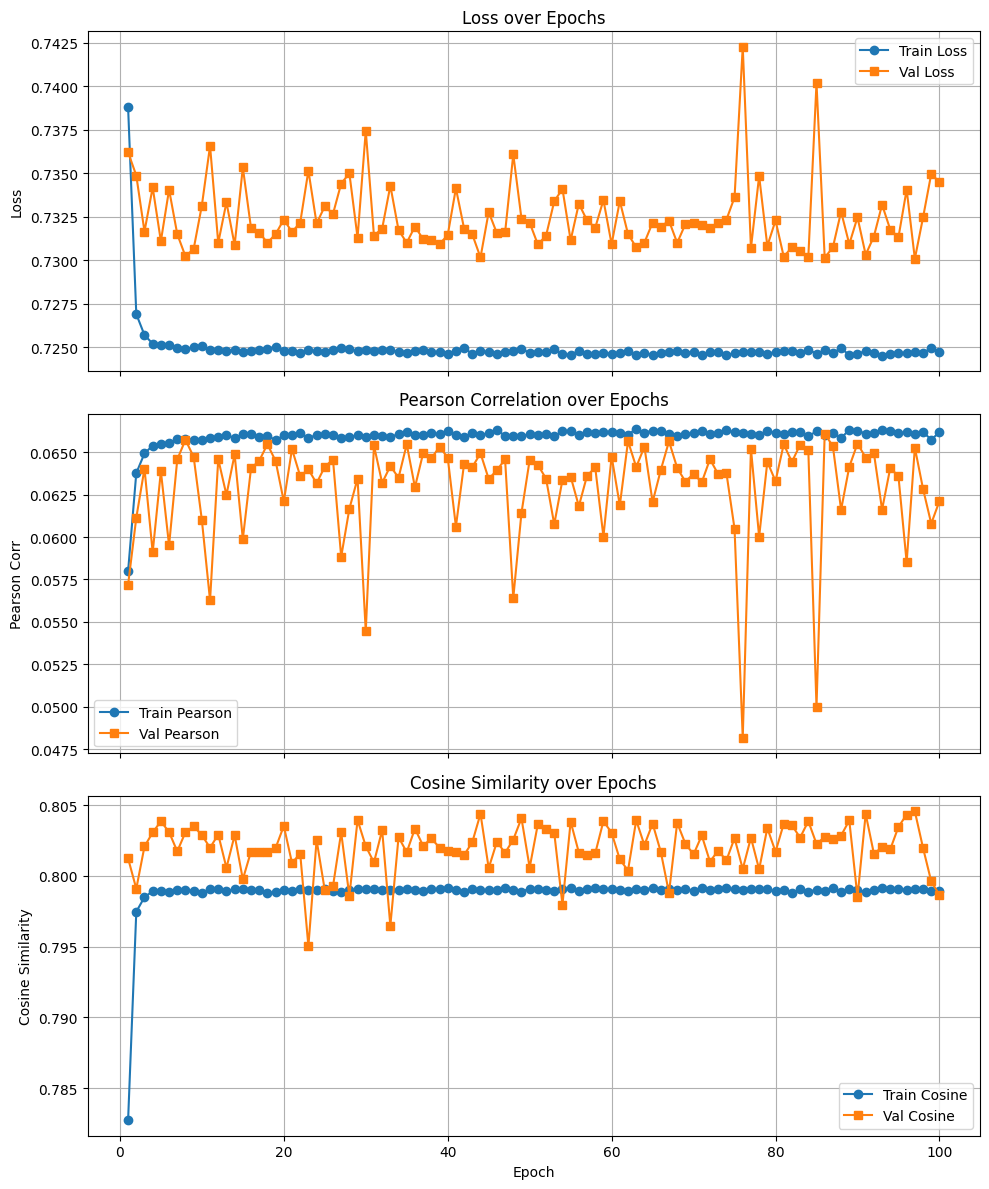

In [45]:
# Load the log file
log_df = pd.read_csv("tgn_eeg_log.csv")

# Plotting
fig, axs = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

# Plot Loss
axs[0].plot(log_df['epoch'], log_df['train_loss'], label='Train Loss', marker='o')
axs[0].plot(log_df['epoch'], log_df['val_loss'], label='Val Loss', marker='s')
axs[0].set_ylabel("Loss")
axs[0].set_title("Loss over Epochs")
axs[0].legend()
axs[0].grid(True)

# Plot Pearson Correlation
axs[1].plot(log_df['epoch'], log_df['train_pearson'], label='Train Pearson', marker='o')
axs[1].plot(log_df['epoch'], log_df['val_pearson'], label='Val Pearson', marker='s')
axs[1].set_ylabel("Pearson Corr")
axs[1].set_title("Pearson Correlation over Epochs")
axs[1].legend()
axs[1].grid(True)

# Plot Cosine Similarity
axs[2].plot(log_df['epoch'], log_df['train_cosine'], label='Train Cosine', marker='o')
axs[2].plot(log_df['epoch'], log_df['val_cosine'], label='Val Cosine', marker='s')
axs[2].set_xlabel("Epoch")
axs[2].set_ylabel("Cosine Similarity")
axs[2].set_title("Cosine Similarity over Epochs")
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()

In [46]:
def plot_predictions(model, X_test, y_test, num_examples=5):
    model.eval()
    device = next(model.parameters()).device

    X_test = X_test.to(device)
    y_test = y_test.to(device)

    with torch.no_grad():
        y_pred = model(X_test)

    y_pred = y_pred.cpu().numpy()
    y_true = y_test.cpu().numpy()

    for i in range(min(num_examples, len(y_true))):
        plt.figure(figsize=(10, 3))
        plt.plot(y_true[i], label='True Envelope', linewidth=2)
        plt.plot(y_pred[i], label='Predicted Envelope', linestyle='--')
        plt.title(f"Sample {i+1}")
        plt.xlabel("Time")
        plt.ylabel("Amplitude")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

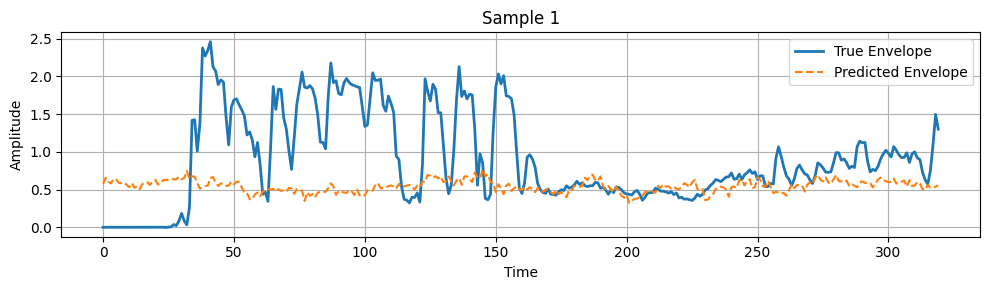

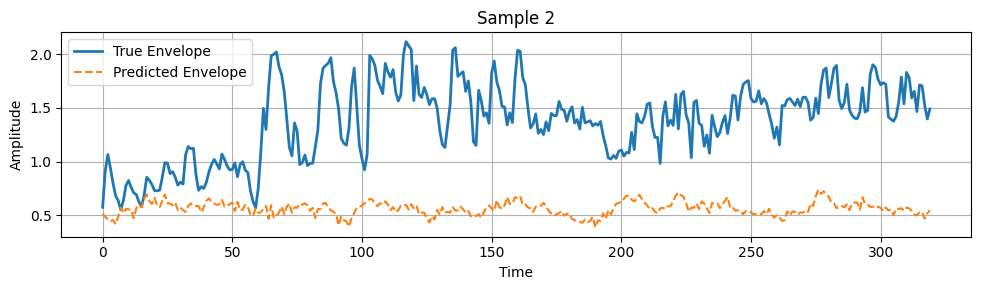

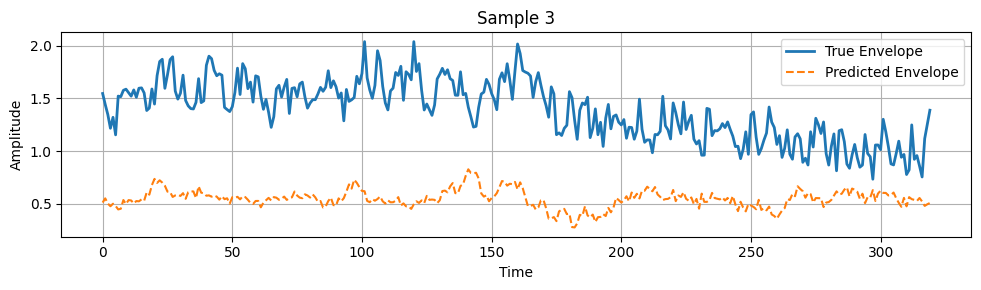

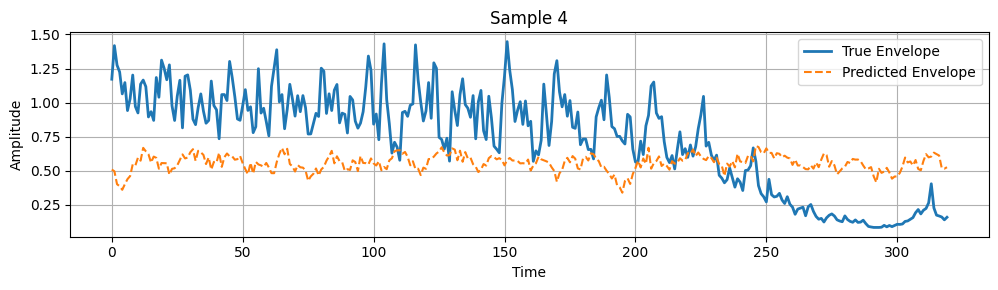

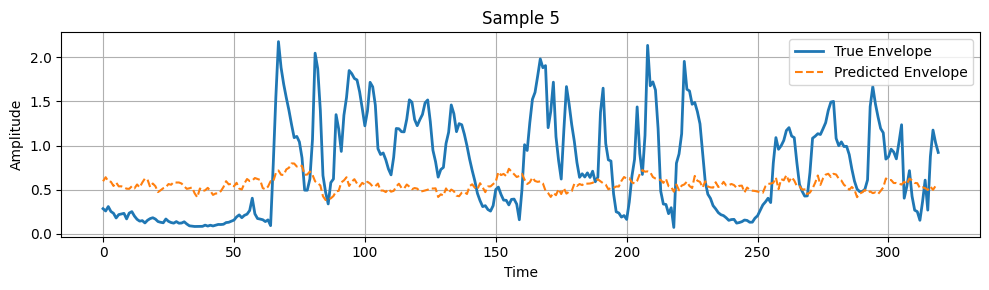

In [47]:
plot_predictions(model, X_test, y_test, num_examples=5)